## 1. Importar librerias

In [73]:
# Librerias basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Metricas
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## 2. Importar y analizar dataset

In [2]:
data = pd.read_csv('data/heart-disease.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Copiamos y pegamos la informacion que tenemos del dataset de Kaggle
1. age
sex
2. chest pain type (4 values)
3. resting blood pressure
4. serum cholestoral in mg/dl
5. fasting blood sugar > 120 mg/dl
6. resting electrocardiographic results (values 0,1,2)
7. maximum heart rate achieved
8. exercise induced angina
9. oldpeak = ST depression induced by exercise relative to rest
10. the slope of the peak exercise ST segment
11. number of major vessels (0-3) colored by flourosopy
12. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

Podemos ver que se trata de un problema de clasificación, donde la columna **target** identifica si se trata de un problema de corazón o no, siendo **0 = sin problema y 1= problema**

## 3. Depurar y dividir el dataset

In [3]:
# Primero buscamos si hay algun valor en blanco en al columna target
data['target'].isna().sum()

np.int64(0)

In [4]:
# En este caso, no hay huecos, pero en caso de haberlos podríamos:
print(data.shape)
data = data.dropna(subset=['target'])
data.shape

(303, 14)


(303, 14)

In [5]:
# Comprobamos el resto de columnas
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
# En este caso, no va a hacer falta, pero si hubiera datos vacíos, se podría determinar realizar distintas acciones, tales como
# eliminar el dato o asignarle la media o la moda

In [7]:
# Asignamos los valores de datos input y el objetivo
X = data.drop(['target'], axis=1)
print(X.head())

y = data['target']
print(y.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  
0   0     1  
1   0     2  
2   0     2  
3   0     2  
4   0     2  
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [8]:
# Dividimos en sets de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

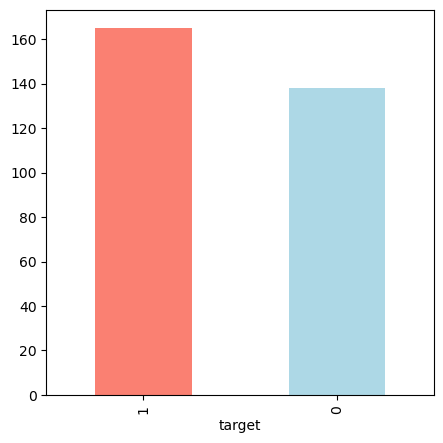

In [9]:
# Comprobamos si nuestro dataset está equilibrado
y.value_counts()

ax, fig = plt.subplots(figsize=(5,5))
y.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.show()

Nuestro dataset está equilibrado, esto afecta al tipo de métricas que usaremos para determinar el mejor modelo

## 4. Seleccionar modelos

Para ello consultamos el mapa de Sklearn:

Se trata de un modelo de clasificación con un número moderado de muestras y de datos numéricos, por lo tanto:
* Linear SVC
* KN Neighbors
* Ensemblers - RandomForestClassifier

In [18]:
# Creamos un diccionario con los modelos
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighbors': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}

## 5. Entrenar y evaluar modelos

C:\Users\Pablo\Desktop\ml_course\heart-disease-project\env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'LogisticRegression': 0.7704918032786885, 'KNeighbors': 0.6885245901639344, 'RandomForest': 0.7540983606557377}


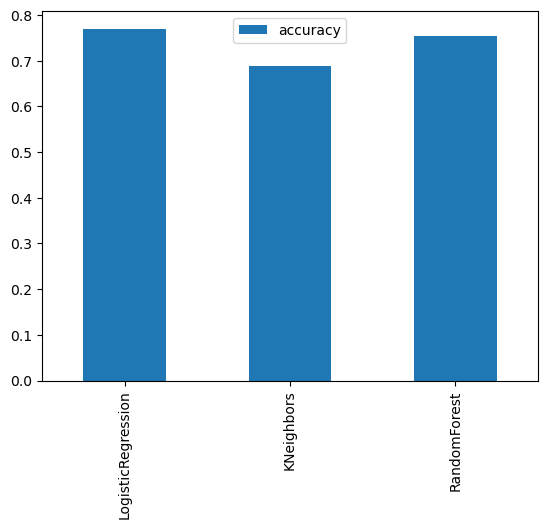

In [19]:
# Creamos un diccionario para alamcenar las puntuaciones
model_scores = {}

# Entrenamos los modelos y los evaluamos
for name, model in models.items():
    model.fit(X_train, y_train)
    model_scores.update({name: model.score(X_test, y_test)})
    
print(model_scores)

model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar()
plt.show()

Parece que LogisticRegression y RandomForest son los que tienen un mejor performance. De todas formas, puede merecer la pena, considerar otros métodos de evaluación, tales como el f1 y emplear la cross-validation para asegurarnos que estamos tomando las mejores decisiones

## 6. Hyperparameter tuning y cross-validation

### 6.1 RandomizedSearchCV

In [42]:
# Grid
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [43]:
# Randomized search CV
rs_log_reg = RandomizedSearchCV(estimator = LogisticRegression(),
                               param_distributions = log_reg_grid,
                               n_iter = 20,
                               cv = 5,
                               verbose = True)

rs_rf = RandomizedSearchCV(estimator = RandomForestClassifier(),
                          param_distributions = rf_grid,
                          n_iter = 20,
                          cv = 5,
                          verbose = True)

In [44]:
np.random.seed(42)
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [45]:
np.random.seed(42)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [46]:
print(f'Logistic regression accuracy: {rs_log_reg.score(X_test, y_test)}')
print(f'RandomForest parameters: {rs_rf.score(X_test, y_test)}')

Logistic regression accuracy: 0.7213114754098361
RandomForest parameters: 0.7540983606557377


In [47]:
print(f'Logistic regression parameter: {rs_log_reg.best_params_}')
print(f'RandomForest parameters: {rs_rf.best_params_}')

Logistic regression parameter: {'solver': 'liblinear', 'C': np.float64(29.763514416313132)}
RandomForest parameters: {'n_estimators': np.int64(560), 'min_samples_split': np.int64(12), 'min_samples_leaf': np.int64(9), 'max_depth': 10}


### 6.2 GridSearchCV

Parece que RandomForest arroja los mejores resultados, vamos a utilizar GridSearch para obtener los mejores parámetros para este modelo

In [48]:
#RandomForest parameters: {'n_estimators': np.int64(560), 'min_samples_split': np.int64(12), 'min_samples_leaf': np.int64(9), 'max_depth': 10}

# Ajustamos los parametros a valores alrededor de los obtenidos con el anterior algoritmo de búsqueda
rf_grid = {"n_estimators": np.arange(450, 600, 50),
           "max_depth": [5, 10, 15],
           "min_samples_split": np.arange(10, 16, 2),
           "min_samples_leaf": np.arange(8, 12, 2)}

gs_rf = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=rf_grid,
                    cv=5, 
                    verbose=True)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': array([ 8, 10]),
                         'min_samples_split': array([10, 12, 14]),
                         'n_estimators': array([450, 500, 550])},
             verbose=True)

In [49]:
gs_rf.score(X_test, y_test)

0.7704918032786885

## 7. Otros métodos de evaluación

In [50]:
# Definimos el modelo con los mejores parámetros que hemos encontrado
gs_rf.best_params_

{'max_depth': 10,
 'min_samples_leaf': np.int64(10),
 'min_samples_split': np.int64(12),
 'n_estimators': np.int64(450)}

In [52]:
clf = RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=12, n_estimators=450)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=12,
                       n_estimators=450)

In [54]:
# Predecir
y_preds = clf.predict(X_test)

### 7.1 Confusion matrix

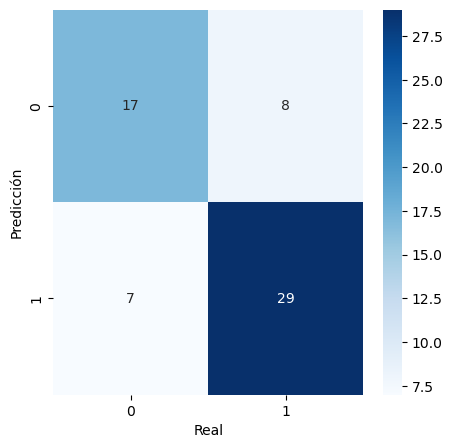

In [72]:
confusion_score = confusion_matrix(y_test, y_preds)
sns.color_palette('pastel')

ax, fig = plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_score, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.show()

### 7.2 Classification report

In [79]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69        25
           1       0.78      0.81      0.79        36

    accuracy                           0.75        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.75      0.75        61

